# Predicting who would survive the _Titanic_ disaster

In [17]:
import numpy as np
import pandas as pd
# import re
# import xgboost as xgb
# import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# from IPython.display import Image as PImage
# from subprocess import check_call
# from PIL import Image, ImageDraw, ImageFont

In [2]:
titanic_data = pd.read_csv('titanic.csv')
titanic_data

,survived,pclass,name,sex,age,siblings_spouses,parents_children,ticket,fare,cabin,embarked,boat,body,homedest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,0,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,0,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,3,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,?,C,?,328,?
1305,0,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,?,C,?,?,?
1306,0,3,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,?,C,?,304,?
1307,0,3,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,?,C,?,?,?


# Looking at the data

Now we have the data, we can plot a few graphs to understand who did or didn't survive the _Titanic_ disaster.

The first question is, how many people were aboard? How were they distributed by class and gender?

In [3]:
titanic_data[['pclass', 'sex']].value_counts().sort_index()#.unstack().plot.bar(stacked=True);

pclass  sex   
1       female    144
        male      179
2       female    106
        male      171
3       female    216
        male      493
Name: count, dtype: int64

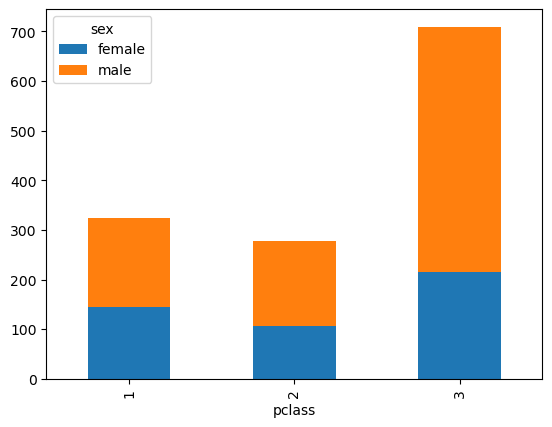

In [4]:
titanic_data[['pclass', 'sex']].value_counts().sort_index().unstack().plot.bar(stacked=True);

This shows that there were roughly equal numbers of first and second class passengers, and a about twice that for third class. It also shows that first class was about half women, second class had a few more men than women, but third class was over two-thirds women.

The _Titanic_ disaster is reputed for the claim of "women and children first!" The idea is that women and children were given priority when getting in the limited number of lifeboats. If that is the case, we should see women and children surviving at a higher rate than men.

We can see if that's true by plotting the number of survivors and casualties, split by gender.

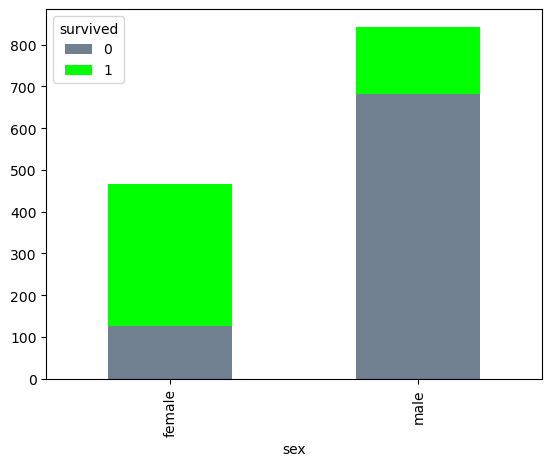

In [5]:
titanic_data[['sex', 'survived']].value_counts().sort_index().unstack().plot.bar(stacked=True, color=['slategray', 'lime']);

This clearly shows that a much greater proportion of women survived than men.

We can also ask about whether children survived. To make the plot clearer, we group the passengers into bands of ten years each; the labels show the "tens" digit of their ages. Again, we plot how many in each age band survived.

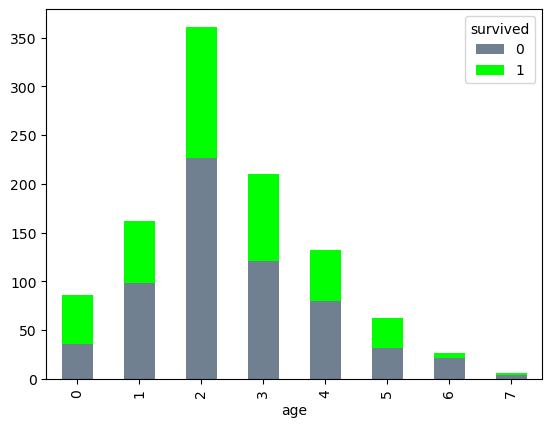

In [6]:
# t = titanic_data[['age', 'survived']]
t = pd.concat([pd.cut(titanic_data.age, bins=8, labels=list(range(8))), titanic_data.survived], axis='columns')
t = t.value_counts().sort_index().unstack().fillna(0)
# t = t.div(t.sum(axis='columns'), axis='rows')
t.plot.bar(stacked=True, color=['slategray', 'lime']);

The numbers in each age band are very different, so it's hard to draw conclusions. Let's scale the bars so they're all the same height, and we can directly see the proportions. 

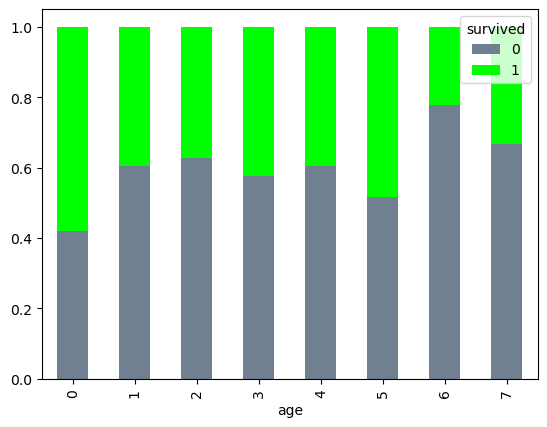

In [7]:
t = t.div(t.sum(axis='columns'), axis='rows')
t.plot.bar(stacked=True, color=['slategray', 'lime']);

This shows that children did have a higher survival rate than others, but it wasn't a huge difference.

Another element to look at is the class of the passengers. Was the _Titanic_ disaster one where "rank hath its priviliges" and the better-off passengers were more likely to survive?

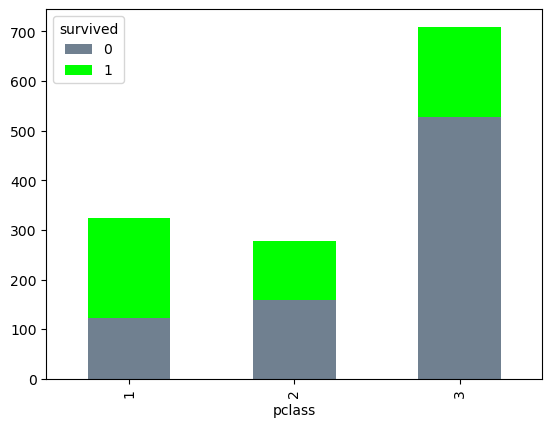

In [8]:
titanic_data[['pclass', 'survived']].value_counts().sort_index().unstack().plot.bar(stacked=True, color=['slategray', 'lime']);

There's a clear difference among the classes, with a much higher proportion of first class passengers surviving than other classes, and most of the third-class passengers dying.

We can also look at the combination of class and gender. Did the "women and children first" approach apply differently in different classes?

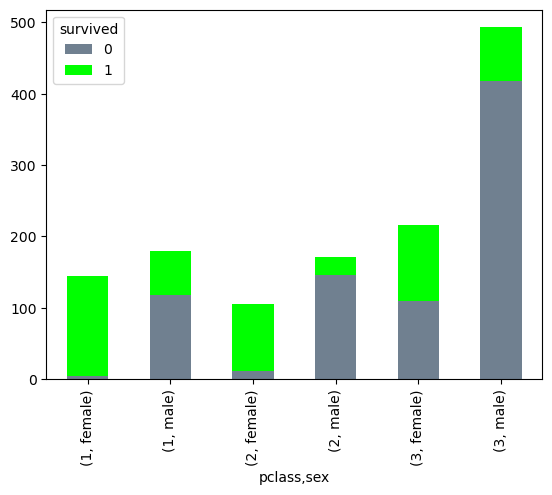

In [9]:
titanic_data[['pclass', 'sex', 'survived']].value_counts().sort_index().unstack().plot.bar(stacked=True, color=['slategray', 'lime']);

The evidence suggests that yes, it did, but in all classes the women had a higher survivial rate than the men. The difference is most stark among the second-class passengers, where most of the men died but most of the women survived.

# Machine learning

Looking at some overviews of the data can help us understand some parts of the human cost of the disaster, but they can only go so far. Another approach is to use machine learning to understand the fates of people on the _Titanic_. 

In this activity we'll use a _decision tree_. This is like a game of _Twenty Questions_ or some bird identification keys. When you're trying to classify some item, you ask a series of yes/no questions. Based on the answers, you move down the tree to the next question. As you go, you're getting a clearer idea of the outcome.




When it comes to learning a decision tree, we start with some data, labelled with its true classification. 


## Data preparation

One limitation of the decision tree software we're using is that it only accepts data in strictly numerical format, so we need to do a little bit of pre-processing of the data. 

The first is to create two Boolean fields, for whether a person has a cabin (we don't care which cabin number) and whether someone is female.

In [10]:
titanic_data['has_cabin'] = titanic_data.cabin != '?'
titanic_data['is_female'] = titanic_data.sex == 'female'
titanic_data

,survived,pclass,name,sex,age,siblings_spouses,parents_children,ticket,fare,cabin,embarked,boat,body,homedest,has_cabin,is_female
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO",True,True
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON",True,False
2,0,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON",True,True
3,0,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON",True,False
4,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON",True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,3,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,?,C,?,328,?,False,True
1305,0,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,?,C,?,?,?,False,True
1306,0,3,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,?,C,?,304,?,False,False
1307,0,3,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,?,C,?,?,?,False,False


Next, we'll drop the data we can't use (such as name and lifeboat number) and keep the data we can (such as class, and number of siblings & spouses aboard). We'll also drop any rows with incomplete data. Finally, we create three new columns, each showing if this passenger embarked at a particular port.

In [12]:
keep_columns = ['survived', 'pclass', 'age','siblings_spouses', 'parents_children', 'embarked', 'fare', 'has_cabin', 'is_female']
titanic_data = titanic_data[keep_columns].dropna()
titanic_data = titanic_data[titanic_data.embarked != '?']
titanic_data = pd.get_dummies(titanic_data, columns='embarked'.split())
titanic_data

,survived,pclass,age,siblings_spouses,parents_children,fare,has_cabin,is_female,embarked_C,embarked_Q,embarked_S
0,1,1,29.0000,0,0,211.3375,True,True,False,False,True
1,1,1,0.9167,1,2,151.5500,True,False,False,False,True
2,0,1,2.0000,1,2,151.5500,True,True,False,False,True
3,0,1,30.0000,1,2,151.5500,True,False,False,False,True
4,0,1,25.0000,1,2,151.5500,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
1301,0,3,45.5000,0,0,7.2250,False,False,True,False,False
1304,0,3,14.5000,1,0,14.4542,False,True,True,False,False
1306,0,3,26.5000,0,0,7.2250,False,False,True,False,False
1307,0,3,27.0000,0,0,7.2250,False,False,True,False,False


In [55]:
rose_jack = pd.DataFrame([{'survived': 1, 'pclass': 1, 'age': 17, 'siblings_spouses': 0, 'parents_children': 1, 'fare': 200, 
                          'has_cabin': True, 'is_female': True, 'embarked_C': False, 'embarked_Q': False, 'embarked_S': True},
                         {'survived': 0, 'pclass': 3, 'age': 20, 'siblings_spouses': 0, 'parents_children': 0, 'fare': 10, 
                          'has_cabin': False, 'is_female': False, 'embarked_C': False, 'embarked_Q': False, 'embarked_S': True}])
rose_jack

,survived,pclass,age,siblings_spouses,parents_children,fare,has_cabin,is_female,embarked_C,embarked_Q,embarked_S
0,1,1,17,0,1,200,True,True,False,False,True
1,0,3,20,0,0,10,False,False,False,False,True


In [56]:
X_rose_jack = rose_jack.drop(['survived'], axis='columns').astype(float).values
y_rose_jack = rose_jack.survived.astype(float).values

We now split the data into two parts: the information we're predicting, and the information we're using to make this prediction. By convention, we use the name _X_ for the information we're given and the name _y_ for the information to be predicted. We also convert the data from a Dataframe to a raw array, as is needed by the decision tree.

In [14]:
titanic_x = titanic_data.drop(['survived'], axis='columns').astype(float).values
titanic_y = titanic_data.survived.astype(float).values
titanic_x

array([[ 1.    , 29.    ,  0.    , ...,  0.    ,  0.    ,  1.    ],
       [ 1.    ,  0.9167,  1.    , ...,  0.    ,  0.    ,  1.    ],
       [ 1.    ,  2.    ,  1.    , ...,  0.    ,  0.    ,  1.    ],
       ...,
       [ 3.    , 26.5   ,  0.    , ...,  1.    ,  0.    ,  0.    ],
       [ 3.    , 27.    ,  0.    , ...,  1.    ,  0.    ,  0.    ],
       [ 3.    , 29.    ,  0.    , ...,  0.    ,  0.    ,  1.    ]])

In [15]:
titanic_y

array([1., 1., 0., ..., 0., 0., 0.])

The final data preparation step is to split the data into training and testing data. You'll see why this is important in a moment.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(titanic_x, titanic_y, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((834, 10), (834,), (209, 10), (209,))

## First decision tree

In [79]:
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [80]:
decision_tree.score(X_train, y_train)

0.815347721822542

In [81]:
decision_tree.get_depth()

3

In [82]:
decision_tree.get_n_leaves()

8

In [83]:
y_pred = decision_tree.predict(X_train)

In [84]:
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.87      0.85       492
         1.0       0.80      0.73      0.77       342

    accuracy                           0.82       834
   macro avg       0.81      0.80      0.81       834
weighted avg       0.81      0.82      0.81       834



In [85]:
decision_tree.score(X_test, y_test)

0.8133971291866029

In [86]:
y_pred = decision_tree.predict(X_test)

In [87]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.85      0.85       126
         1.0       0.77      0.76      0.76        83

    accuracy                           0.81       209
   macro avg       0.81      0.80      0.80       209
weighted avg       0.81      0.81      0.81       209



In [88]:
decision_tree.predict(X_rose_jack)

array([1., 0.])

In [89]:
n_nodes = decision_tree.tree_.node_count
children_left = decision_tree.tree_.children_left
children_right = decision_tree.tree_.children_right
feature = decision_tree.tree_.feature
threshold = decision_tree.tree_.threshold

node_indicator = decision_tree.decision_path(X_test)
leaf_id = decision_tree.apply(X_test)

column_names = list(titanic_data.drop(['survived'], axis='columns').columns)

def show_prediction_path(sample_id):

    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]

    print((f"Rules used to predict sample {sample_id} "
           f"(actual class {y_test[sample_id]}, predicted class {pred_y[sample_id]}):\n"))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue

        # check if value of the split feature for sample 0 is below threshold
        if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print(
            (f"decision node {node_id} : (X_test[{sample_id}, {feature[node_id]}] = "
             f"{X_test[sample_id, feature[node_id]]:2.2f}) "
             f"{threshold_sign} {threshold[node_id]:2.2f}) " 
             f"({column_names[feature[node_id]]})")
            )

In [90]:
# n_nodes = decision_tree.tree_.node_count
# children_left = decision_tree.tree_.children_left
# children_right = decision_tree.tree_.children_right
# feature = decision_tree.tree_.feature
# threshold = decision_tree.tree_.threshold

# node_indicator = decision_tree.decision_path(titanic_x)
# leaf_id = decision_tree.apply(titanic_x)

# column_names = list(titanic3.drop(['survived'], axis='columns').columns)

# def show_prediction_path(sample_id):

#     # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
#     node_index = node_indicator.indices[
#         node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
#     ]

#     print((f"Rules used to predict sample {sample_id} "
#            f"(actual class {titanic_y[sample_id]}, predicted class {pred_y[sample_id]}):\n"))
#     for node_id in node_index:
#         # continue to the next node if it is a leaf node
#         if leaf_id[sample_id] == node_id:
#             continue

#         # check if value of the split feature for sample 0 is below threshold
#         if titanic_x[sample_id, feature[node_id]] <= threshold[node_id]:
#             threshold_sign = "<="
#         else:
#             threshold_sign = ">"

#         print(
#             (f"decision node {node_id} : (titanic_x[{sample_id}, {feature[node_id]}] = "
#              f"{titanic_x[sample_id, feature[node_id]]:2.2f}) "
#              f"{threshold_sign} {threshold[node_id]:2.2f}) " 
#              f"({column_names[feature[node_id]]})")
#             )

In [91]:
show_prediction_path(100)

Rules used to predict sample 100 (actual class 0.0, predicted class 1.0):

decision node 0 : (X_test[100, 6] = 0.00) <= 0.50) (is_female)
decision node 1 : (X_test[100, 1] = 2.00) <= 12.50) (age)
decision node 2 : (X_test[100, 2] = 3.00) > 2.50) (siblings_spouses)


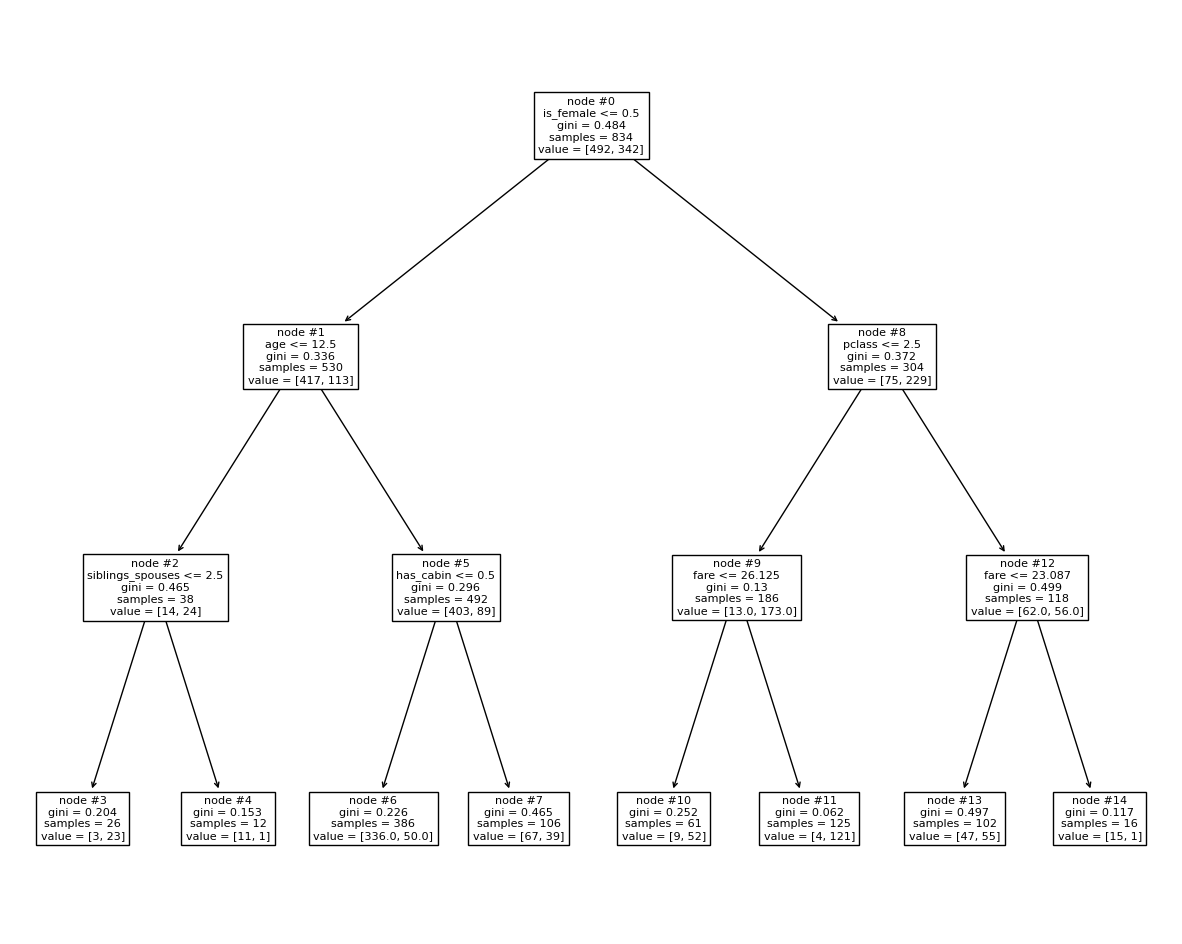

In [92]:
plt.figure(figsize=(15, 12))
tree.plot_tree(decision_tree,
              feature_names=column_names,
              node_ids=True,
              );